# Gold nanoparticle validation

Plasmonic nanoparticles can exhibit interesting electromagnetic properties at certain frequencies, such as a negative real part of the relative permittivty. Due to their high electrical conductivity, gold nanoparticles can be challenging to model: the rapid field variations inside and near the particles requires a fine local discretization. Therefore, an intelligent non-uniform meshing scheme is essential to make sure that the particle is well resolved, while the empty space around it does not lead to wasted simulation effort.

Scattering from a 10 nm gold sphere is modeled in this example, and both near and far fields are compared to the analytical Mie series.

To obtain the scattered field, two simulations will be run:
* one with the sphere to compute the total field near the sphere, and
* one without the sphere, to compute just the incident field and subtract it from the above to get the scattered field.

The far fields are computed by a near-to-far transformation of the near fields recorded on a closed surface around the sphere. A non-uniform mesh is carefully designed to make sure the sphere is well resolved without a significant sacrifice in efficiency.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

[16:00:32] INFO     Using client version: 1.8.0                               ]8;id=914995;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=356663;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#107\107]8;;\

## Define the structure and boundary conditions
Note the special treatment in creating the mesh: we need to make sure that the mesh is sufficiently fine within the sphere, but we can also make use of `Tidy3D`'s non-uniform meshing algorithm to have a coarser grid outside the sphere, for better efficiency.

In [2]:
# radius and location of the nanoparticle
radius = 5e-3
center = [0, 0, 0]

# nanoparticle material
medium = td.material_library['Au']['RakicLorentzDrude1998']

# free space central wavelength of the pulse excitation
wavelength = 530e-3
f0 = td.C_0 / wavelength

# Bandwidth in Hz
fwidth = f0 / 5.0
fmin = f0 - fwidth
fmax = f0 + fwidth
wavelength_max = td.C_0 / fmin
wavelength_min = td.C_0 / fmax

# the nanoparticle is very electrically small in the frequency range considered here, and meshing
# based on a standard 10-30 points per wavelength would lead to a grid too coarse to resolve the
# curvature of the sphere, so to ensure a sufficiently fine mesh in the particle, a phantom sphere 
# is created with an extremely large permittivity, which is chosen so that there are at least
# ``cells_in_particle`` cells along the diameter of the sphere
cells_per_wavelength = 60
cells_in_particle = 60
phantom_electrical_diameter = cells_in_particle / cells_per_wavelength
wavelength_in_phantom = 2 * radius * phantom_electrical_diameter
wavelength_ratio = wavelength_in_phantom / wavelength_max
epsr_phantom = (1.0 / wavelength_ratio) ** 2
phantom = td.Structure(
    geometry=td.Sphere(center=center, radius=radius), medium=td.Medium(permittivity=epsr_phantom))

# create the sphere
sphere = td.Structure(geometry=td.Sphere(center=center, radius=radius), medium=medium)
geometry = [sphere]

# distance between the surface of the sphere and the start of the PML layers along each cartesian direction
buffer_PML = wavelength_max / 2

# set the full simulation size along x, y, and z
sim_size = [buffer_PML + 2 * radius + buffer_PML] * 3

# define PML layers on all sides
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())


## Create Source

For our incident field, we create a plane wave incident from below the sphere polarized in the x direction.

In [3]:
# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, offset=offset)

# place the source below the sphere, propagating in the +z direction
source = td.PlaneWave(
    center=(0,0,-(radius + 3 * buffer_PML / 4)),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    direction='+',
    pol_angle=0)

# Simulation run time past the source decay (around t=2*offset/fwidth)
run_time = 10 / fwidth


## Create Monitor

Next, we define the monitors that will capture the near field data.

First, we create a `Near2FarAngleMonitor` which allows performing the far field transformation on GPUs during the solver run.

Next, we create a point `FieldMonitor` to record the field a point just above the sphere.

In [4]:
# distance between the sphere and the near field monitor along each cartesian direction
buffer_mon = 3 * radius

# create a volume monitor around the sphere
mon_size = 2 * radius + 2 * buffer_mon

# set the observation angles
phis = [np.pi/2]
thetas = [0]

# set the list of frequencies at which to compute far fields
num_freqs = 100
freqs = np.linspace(f0-fwidth, f0+fwidth, 100)

# create the near-to-far field monitor
monitor_n2f = td.Near2FarAngleMonitor(
    center=center,
    size=[mon_size] * 3,
    freqs=list(freqs),
    name='n2f',
    phi=phis,
    theta=thetas
)

monitor_near = td.FieldMonitor(
    center=[0, 0, 2*radius],
    size=[0, 0, 0],
    freqs=list(freqs),
    name='near',
)

monitor_flux = td.FluxMonitor(
    center=[0, 0, 1.5*radius],
    size=[10*radius, 10*radius, 0],
    freqs=list(freqs),
    name='flux',
)

monitor_thru = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=list(freqs),
    name='thru',
)

monitors = [monitor_n2f, monitor_near, monitor_flux, monitor_thru]

## Create Simulation

Now we can put everything together and define the two simulation classes: with the sphere to get the total field, and without the sphere to get the incident field. Since the incident field must be subtracted from the total field, we need to make sure the FDTD grid is identical in the two simulations.

In [5]:
grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=cells_per_wavelength,
    override_structures=[phantom],
)
grid_spec_empty = td.GridSpec.auto(
    min_steps_per_wvl=cells_per_wavelength,
    override_structures=[phantom],
)

# create the simulation with the particle
sim = td.Simulation(
    size=sim_size,
    grid_spec = grid_spec,
    structures=geometry,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec
)

# create the reference simulation without the particle
sim_empty = td.Simulation(
    size=sim_size,
    grid_spec = grid_spec_empty,
    structures=[],
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec
)


## Visualize Geometry and Mesh

Let's take a look at the mesh and geometry and make sure everything is defined properly in both simulations.

           INFO     Auto meshing using wavelength 0.5300 defined from        ]8;id=834479;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=343236;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#510\510]8;;\
                    sources.                                                                 

           INFO     Auto meshing using wavelength 0.5300 defined from        ]8;id=731574;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=570003;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#510\510]8;;\
                    sources.                                                                 

<AxesSubplot:title={'center':'cross section at y=0.00'}, xlabel='x', ylabel='z'>

<Figure size 648x216 with 2 Axes>

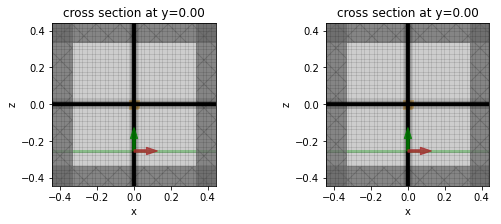

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
sim.plot(y=0, ax=ax1)
sim.plot_grid(y=0, ax=ax1)
sim_empty.plot(y=0, ax=ax2)
sim_empty.plot_grid(y=0, ax=ax2)

## Run Simulations

Now we can run both simulations over time and measure the results


In [7]:
# Run simulation
sim_data = web.run(sim, task_name='plasmonic_nanoparticle', path='data/plasmonic_nanoparticle.hdf5')
sim_empty_data = web.run(sim_empty, task_name='plasmonic_nanoparticle_empty', path='data/plasmonic_nanoparticle_empty.hdf5')

           INFO     Using Tidy3D credentials from stored file.                     ]8;id=92816;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=482748;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#70\70]8;;\

[16:00:34] INFO     Authentication successful.                                     ]8;id=262202;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=930317;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#30\30]8;;\

           INFO     Uploaded task 'plasmonic_nanoparticle' with task_id         ]8;id=530865;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=264309;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '365d1f26-86a4-4479-9843-3302d6d7a2d3'.                                  

Output()

[16:00:37] INFO     status = queued                                             ]8;id=607070;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=470322;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#264\264]8;;\

Output()

[16:00:45] INFO     Maximum flex unit cost: 1.20                                ]8;id=397552;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=579096;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#255\255]8;;\

           INFO     status = preprocess                                         ]8;id=694004;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=860528;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#276\276]8;;\

[16:00:52] INFO     starting up solver                                          ]8;id=204885;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=364208;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#280\280]8;;\

[16:01:03] INFO     running solver                                              ]8;id=987426;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=74327;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#286\286]8;;\

Output()

[16:02:15] INFO     early shutoff detected, exiting.                            ]8;id=342455;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=605629;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#297\297]8;;\

           INFO     status = postprocess                                        ]8;id=825650;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=761021;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#303\303]8;;\

Output()

[16:02:36] INFO     status = success                                            ]8;id=843531;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=129535;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#309\309]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=982265;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=183212;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#581\581]8;;\
                    "data/plasmonic_nanoparticle.hdf5"                                       

Output()

[16:03:28] INFO     loading SimulationData from                                 ]8;id=819042;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=516329;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#403\403]8;;\
                    data/plasmonic_nanoparticle.hdf5                                         

[16:03:29] INFO     Uploaded task 'plasmonic_nanoparticle_empty' with task_id   ]8;id=826299;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=532141;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'f07d80ae-0869-4089-bec2-d2314522f900'.                                  

Output()

[16:03:31] INFO     status = queued                                             ]8;id=13981;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=312607;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#264\264]8;;\

Output()

[16:03:40] INFO     Maximum flex unit cost: 0.87                                ]8;id=837598;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=834791;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#255\255]8;;\

           INFO     status = preprocess                                         ]8;id=868667;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=917470;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#276\276]8;;\

[16:03:50] INFO     starting up solver                                          ]8;id=903467;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=538933;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#280\280]8;;\

[16:04:02] INFO     running solver                                              ]8;id=778497;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=60196;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#286\286]8;;\

Output()

[16:04:57] INFO     early shutoff detected, exiting.                            ]8;id=58368;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=455987;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#297\297]8;;\

           INFO     status = postprocess                                        ]8;id=499355;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=387106;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#303\303]8;;\

Output()

[16:05:06] INFO     status = success                                            ]8;id=512513;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=198497;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#309\309]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=122973;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=181296;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#581\581]8;;\
                    "data/plasmonic_nanoparticle_empty.hdf5"                                 

Output()

[16:05:58] INFO     loading SimulationData from                                 ]8;id=469375;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=492334;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#403\403]8;;\
                    data/plasmonic_nanoparticle_empty.hdf5                                   

In [8]:
# compute scattered radiation vectors by subtracting out the incident fields from the empty simulation
sim_data[monitor_n2f.name].Ntheta.values -= sim_empty_data[monitor_n2f.name].Ntheta.values
sim_data[monitor_n2f.name].Nphi.values -= sim_empty_data[monitor_n2f.name].Nphi.values

sim_data[monitor_n2f.name].Ltheta.values -= sim_empty_data[monitor_n2f.name].Ltheta.values
sim_data[monitor_n2f.name].Lphi.values -= sim_empty_data[monitor_n2f.name].Lphi.values

## Extract the results

In [9]:
# grab the far field data and compute the RCS to compare against Mie series
n2f_data = sim_data[monitor_n2f.name]
RCS = np.squeeze(n2f_data.radar_cross_section().values)

# compute the scattered near fields which we'll also compare against Mie series
Ex_scat = sim_data[monitor_near.name].Ex.values - sim_empty_data[monitor_near.name].Ex.values
Ey_scat = sim_data[monitor_near.name].Ey.values - sim_empty_data[monitor_near.name].Ey.values
Ez_scat = sim_data[monitor_near.name].Ez.values - sim_empty_data[monitor_near.name].Ez.values

Hx_scat = sim_data[monitor_near.name].Hx.values - sim_empty_data[monitor_near.name].Hx.values
Hy_scat = sim_data[monitor_near.name].Hy.values - sim_empty_data[monitor_near.name].Hy.values
Hz_scat = sim_data[monitor_near.name].Hz.values - sim_empty_data[monitor_near.name].Hz.values

E = np.sqrt(
    np.squeeze(Ex_scat)**2 +\
    np.squeeze(Ey_scat)**2 +\
    np.squeeze(Ez_scat)**2
)

H = np.sqrt(
    np.squeeze(Hx_scat)**2 +\
    np.squeeze(Hy_scat)**2 +\
    np.squeeze(Hz_scat)**2
)

flux = sim_data[monitor_flux.name].flux - sim_empty_data[monitor_flux.name].flux

## Plot Results and Compare with Mie Series

[16:06:22] INFO     Auto meshing using wavelength 0.5300 defined from        ]8;id=171592;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=757072;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#510\510]8;;\
                    sources.                                                                 

<Figure size 1080x288 with 6 Axes>

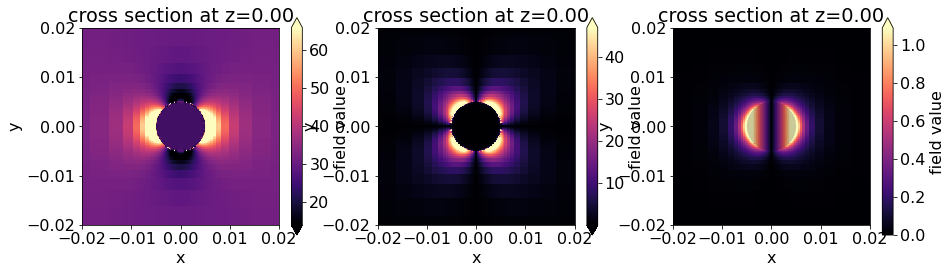

<Figure size 540x360 with 1 Axes>

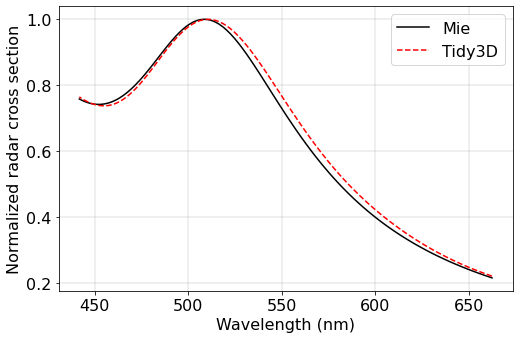

<Figure size 540x360 with 1 Axes>

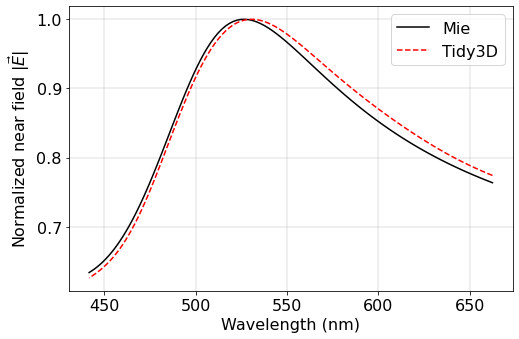

<Figure size 540x360 with 1 Axes>

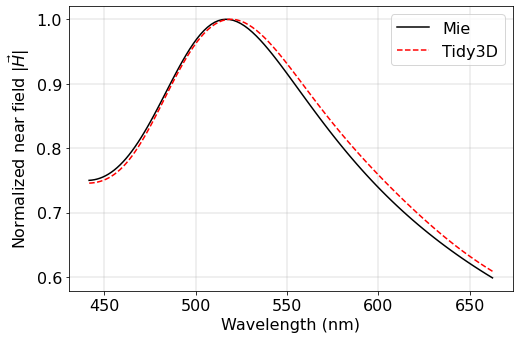

<Figure size 540x360 with 1 Axes>

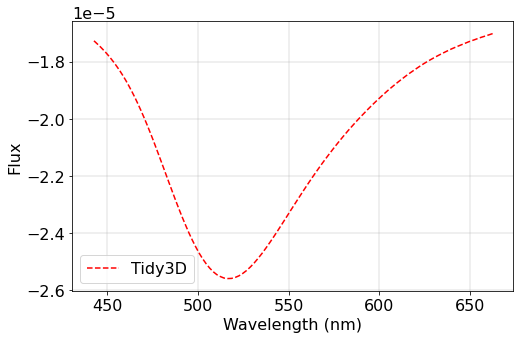

In [11]:
plt.rcParams.update({'font.size': 16})

# load Mie series data
savefile_E = "./data/mie_plasmonic_Eabs.txt"
savefile_H = "./data/mie_plasmonic_Habs.txt"
savefile_RCS = "./data/mie_plasmonic_RCS.txt"

Eabs_mie = np.loadtxt(savefile_E, delimiter='\t', skiprows=1)[:,1]
Habs_mie = np.loadtxt(savefile_H, delimiter='\t', skiprows=1)[:,1]
RCS_mie = np.loadtxt(savefile_RCS, delimiter='\t', skiprows=1)[:,1]

def to_db(val):
    val = np.abs(val)
    val = val / np.max(np.abs(val))
    return 10.0*np.log10(val)

def normalize(val):
    return np.abs(val) / np.max(np.abs(val))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sim_data.plot_field(field_monitor_name='thru', field_name='Ex', val='abs', f=f0, ax=ax[0])
sim_data.plot_field(field_monitor_name='thru', field_name='Ey', val='abs', f=f0, ax=ax[1])
sim_data.plot_field(field_monitor_name='thru', field_name='Ez', val='abs', f=f0, ax=ax[2])
for _ax in ax:
    _ax.set_xlim([-20e-3, 20e-3])
    _ax.set_ylim([-20e-3, 20e-3])

fig, ax = plt.subplots(figsize=(7.5, 5))
ax.plot(td.C_0 / freqs * 1e3, normalize(RCS_mie), '-k', label="Mie")
ax.plot(td.C_0 / freqs * 1e3, normalize(RCS), '--r', label="Tidy3D", mfc='None')
ax.set(xlabel = "Wavelength (nm)",
       ylabel = "Normalized radar cross section",
       yscale = 'linear',
       xscale = 'linear',
       # ylim = [0.2, 1.4]
      )
ax.legend()
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))
ax.plot(td.C_0 / freqs * 1e3, normalize(Eabs_mie), '-k', label="Mie")
ax.plot(td.C_0 / freqs * 1e3, normalize(E), '--r', label="Tidy3D", mfc='None')
ax.set(xlabel = "Wavelength (nm)",
       ylabel = "Normalized near field |$\\vec{E}$|",
       yscale = 'linear',
       xscale = 'linear',
       # ylim = [0.2, 1.4]
      )
ax.legend()
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))
ax.plot(td.C_0 / freqs * 1e3, normalize(Habs_mie), '-k', label="Mie")
ax.plot(td.C_0 / freqs * 1e3, normalize(H), '--r', label="Tidy3D", mfc='None')
ax.set(xlabel = "Wavelength (nm)",
       ylabel = "Normalized near field |$\\vec{H}$|",
       yscale = 'linear',
       xscale = 'linear',
       # ylim = [0.2, 1.4]
      )
ax.legend()
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))
# ax.plot(td.C_0 / freqs * 1e3, flux_mie, '-k', label="Mie")
ax.plot(td.C_0 / freqs * 1e3, flux, '--r', label="Tidy3D", mfc='None')
ax.set(xlabel = "Wavelength (nm)",
       ylabel = "Flux",
       yscale = 'linear',
       xscale = 'linear',
       # ylim = [0.2, 1.4]
      )
ax.legend()
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.tight_layout()
